In [1]:
FILE_PATH ="DS_store/MSFT.csv"
EXPORT_Model  = "Stock_prediction_microsoft.pkl"

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
import pickle as pk

In [39]:
template_style = "plotly_dark"

In [3]:
df=pd.read_csv(FILE_PATH)
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-06,208.830002,211.130005,208.089996,210.699997,203.416351,31897600
1,2020-07-07,210.449997,214.669998,207.990005,208.250000,201.051056,33600700
2,2020-07-08,210.070007,213.259995,208.690002,212.830002,205.472717,33600000


In [4]:
df_close=df.reset_index()["Close"]
df_close.head()

0    210.699997
1    208.250000
2    212.830002
3    214.320007
4    213.669998
Name: Close, dtype: float64

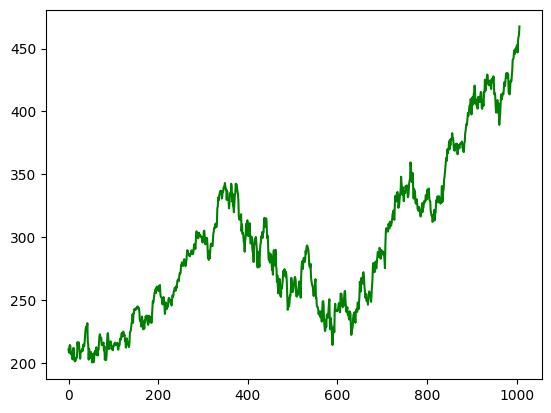

In [5]:
plt.plot(df_close.index,df_close,color="green")

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))
df_close[:10]

array([[0.03858965],
       [0.02941947],
       [0.04656213],
       [0.05213912],
       [0.04970618],
       [0.02500284],
       [0.02979379],
       [0.02863343],
       [0.01321256],
       [0.00931993]])

In [7]:
##splitting dataset into train and test split
training_size=int(len(df_close)*0.65)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]

In [8]:
training_size,test_size

(654, 353)

###  convert an array of values into a dataset matrix

In [9]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [11]:
print("X_train is shape =",X_train.shape)
print("y_train is shape =",y_train.shape)
print("X_test is shape =",X_test.shape)
print("y_test is shape =",y_test.shape)

X_train is shape = (553, 100)
y_train is shape = (553,)
X_test is shape = (252, 100)
y_test is shape = (252,)


### reshape input to be [samples, time steps, features] which is required for LSTM

In [12]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print(X_train.shape)
print(X_test.shape)

(553, 100, 1)
(252, 100, 1)


###  Create the Stacked LSTM model

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### training

In [14]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 7s 151ms/step - loss: 0.0305 - val_loss: 0.0174
Epoch 2/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0072 - val_loss: 0.0753
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0166
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0035 - val_loss: 0.0328
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0064
Epoch 7/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 8/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 9/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 10/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 11/100
9/9 [

###  Lets Do the prediction and check performance metrics

In [15]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 10ms/step


### Transformback to original form

In [16]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics

In [17]:
math.sqrt(mean_squared_error(y_train,train_predict))

267.76104338130114

### Test Data RMSE

In [18]:
math.sqrt(mean_squared_error(y_test,test_predict))

375.32789129973287

### Plotting

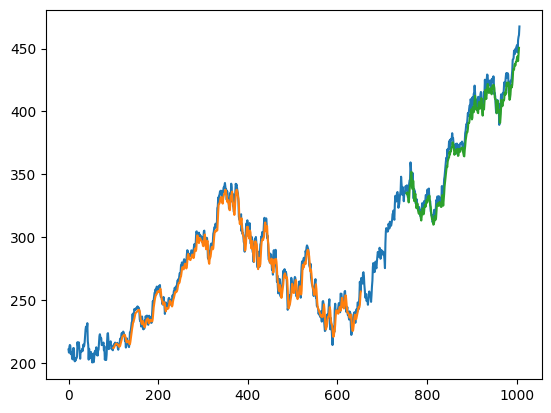

In [19]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [20]:
train_dates =pd.to_datetime(df['Date'])

In [21]:
list(train_dates)[1006].date()

datetime.date(2024, 7, 5)

### Assuming train_dates is a list of datetime objects representing time

In [22]:
# Assuming train_dates is a list of datetime objects representing time
n_future = 90
forecast_period_dates = pd.date_range(list(train_dates)[1006].date(), periods=n_future, freq="1d").tolist()
# Convert time to date
forecast_dates = [date.date() for date in forecast_period_dates]
forecast_dates[:10]

[datetime.date(2024, 7, 5),
 datetime.date(2024, 7, 6),
 datetime.date(2024, 7, 7),
 datetime.date(2024, 7, 8),
 datetime.date(2024, 7, 9),
 datetime.date(2024, 7, 10),
 datetime.date(2024, 7, 11),
 datetime.date(2024, 7, 12),
 datetime.date(2024, 7, 13),
 datetime.date(2024, 7, 14)]

In [23]:
forecast=model.predict(X_train[-n_future:])
forecast[:10]

3/3 [==============================] - 0s 9ms/step


array([[0.13719368],
       [0.13959053],
       [0.14051934],
       [0.13485295],
       [0.13573499],
       [0.14908595],
       [0.16483058],
       [0.17269364],
       [0.15904678],
       [0.13457458]], dtype=float32)

In [34]:
forecast_copies=np.repeat(forecast,train_data.shape[1],axis=1)
forecast_copies.shape

(90, 1)

In [35]:
y_pred_futuer= scaler.inverse_transform(forecast_copies)
y_pred_futuer.shape

(90, 1)

In [36]:
df_forecast=pd.DataFrame({'Date':np.array(forecast_dates).flatten(),'Close':y_pred_futuer.flatten()})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
len(df_forecast)

90

In [37]:
df_forecast.head()

,Date,Close
0,2024-07-05,237.044037
1,2024-07-06,237.684387
2,2024-07-07,237.932541
3,2024-07-08,236.418655
4,2024-07-09,236.654312


In [40]:
fig = px.line(df_forecast,
              x='Date',
              y='Close',
              template = template_style,
              title= '<b>prediction for 90 days</b>')

# Display Plot
fig.show()

In [41]:
df_forecast.to_csv(r'DS_store/prediction_for_stock_microsoft.csv')

In [42]:
pk.dump(model, open(EXPORT_Model, 'wb'))